# Анализ бизнес-показателей

Необходимио произвести анализ данных развлекательного приложения Procrastinate Pro+.
У нас в доступе три датасета: о визитах пользователей, о заказах и о расходах на рекламу.
Нужно изучить данные и ответить на вопросы волнуещие бизнес: откуда приходят пользователи и какими устройствами они пользуются,
сколько стоит привлечение пользователей из различных рекламных каналов;
сколько денег приносит каждый клиент,
когда расходы на привлечение клиента окупаются,
какие факторы мешают привлечению клиентов.

Мы обладаем данными с 1 мая по 27 октября 2019 года:

-визиты: /datasets/visits_info_short.csv

-заказы: /datasets/orders_info_short.csv

-расходы: /datasets/costs_info_short.csv

Иследование будет идти по шагам:

1. Загрузка иподготовка данных

2. Написиание функций для дальнейшего расчета

3. Иследованние и анализ данных

4. Оценка маркетинга

5. Окупаемость рекламы

6. Вывод


### Загрузите данные и подготовьте их к анализу

Загрузите данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`.
- заказы: `/datasets/orders_info_short.csv`. 
- расходы: `/datasets/costs_info_short.csv`.

Изучите данные и выполните предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.

#### Импоритруем все необходимые библиотеки и загружаем файлы

In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

In [2]:
visit = pd.read_csv('/datasets/visits_info_short.csv')
order = pd.read_csv('/datasets/orders_info_short.csv')
cost = pd.read_csv('/datasets/costs_info_short.csv')

#### Проверяем данные на дубликаты, переименовывыаем столбцы и меняем тип столбцов

In [3]:
visit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
visit.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']

In [5]:
visit['session_start'] = pd.to_datetime(visit['session_start'])
visit['session_end'] = pd.to_datetime(visit['session_end'])

In [6]:
visit.duplicated().sum()

0

In [7]:
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [8]:
order.columns = ['user_id','event_dt','revenue']

In [9]:
order['event_dt'] = pd.to_datetime(order['event_dt'])

In [10]:
order.duplicated().sum()

0

In [11]:
cost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [12]:
cost.columns = ['dt','channel','costs']

In [13]:
cost['dt'] = pd.to_datetime(cost['dt'])

In [14]:
cost.duplicated().sum()

0

In [15]:
cost['week'] = cost['dt'].dt.isocalendar().week

In [16]:
cost['month'] = cost['dt'].dt.month

#### Вывод

Импортировали все необходимые билиотеки для дальнейшей работы, загрузили 3 таблицы с даннами. Прривели все названия стобцов к ниженму регистру, поменяли тип данных на datetime там где это необходимо. Проверили на анличия полных дубликатов таких не обнаружено.



### Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [17]:
import time
from datetime import datetime
from datetime import date, timedelta as td

observation_date = datetime(2019, 11, 1).date()  # момент анализа 
horizon_days = 14  # горизонт анализа 

In [18]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'], format="%Y-%m-%d")
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [19]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        visit[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [20]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [21]:
def get_ltv(
    profiles,  # Шаг 1. Получить профили и данные о покупках
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # Шаг 2. Добавить данные о покупках в профили

    result_raw = result_raw.merge(
        # добавляем в профили время совершения покупок и выручку
        purchases[['user_id', 'event_dt', 'revenue']],
        on='user_id',
        how='left',
    )

    # Шаг 3. Рассчитать лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):

        # Шаг 3. Построить таблицу выручки
        # строим «треугольную» таблицу
        result = df.pivot_table(
            index=dims,
            columns='lifetime',
            values='revenue',  # в ячейках — выручка за каждый лайфтайм
            aggfunc='sum',
        )

        # Шаг 4. Посчитать сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)

        # Шаг 5. Вычислить размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )

        # Шаг 6. Объединить размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)

        # Шаг 7. Посчитать LTV
        # делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [22]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [23]:

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [		
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [24]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 20))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(3, 2, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')
     # второй график — динамика ltv
    ax2 = plt.subplot(3, 2, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(3, 2, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(3, 2, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(3, 2, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

#### Минимальная и максимальная дата привлечения пользователей

In [25]:
profiles = get_profiles(visit, order, cost)

In [26]:
profiles['dt'] = profiles['first_ts'].dt.date
profiles['dt'] = pd.to_datetime(profiles['dt'], format="%Y-%m-%d")
profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

In [27]:
observation_date = datetime(2019, 11, 1)

In [28]:
min_analysis_date = profiles['dt'].min()
max_analysis_date= profiles['dt'].max() 

In [29]:
min_analysis_date

Timestamp('2019-05-01 00:00:00')

In [30]:
max_analysis_date

Timestamp('2019-10-27 00:00:00')

In [31]:
observation_date

datetime.datetime(2019, 11, 1, 0, 0)

##### Минимальная и максимальная дата привелечения соответсвуют данныем о пользователях, привлечённых с 1 мая по 27 октября 2019 года

#### Количество пользователей и долю платящих из каждой страны.

In [32]:
region_payer_share = pd.DataFrame()
region_payer_share['users_count'] = profiles.groupby('region')['user_id'].count()
region_payer_share['payer_users_count'] = profiles.query('payer == True').groupby('region')['user_id'].count()
region_payer_share['share'] = 100*(region_payer_share['payer_users_count'] / region_payer_share['users_count'])
region_payer_share.sort_values(by='share', ascending=False).style.format({'share': '{:.1f}%'})

,users_count,payer_users_count,share
region,,,
United States,100002,6902,6.9%
Germany,14981,616,4.1%
UK,17575,700,4.0%
France,17450,663,3.8%


##### Больше всего пользователей из US, так же у них и самая большая доля платящих ползователей

#### Какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи.

In [33]:
device_payer_share = pd.DataFrame()
device_payer_share['users_count'] = profiles.groupby('device')['user_id'].count()
device_payer_share['payer_users_count'] = profiles.query('payer == True').groupby('device')['user_id'].count()
device_payer_share['share'] = 100*(device_payer_share['payer_users_count'] / device_payer_share['users_count'])
device_payer_share.sort_values(by='share', ascending=False).style.format({'share': '{:.1f}%'})

,users_count,payer_users_count,share
device,,,
Mac,30042,1912,6.4%
iPhone,54479,3382,6.2%
Android,35032,2050,5.9%
PC,30455,1537,5.0%


##### Больше всего пользователей на платфоре Iphone  и Android, но доля платящих пользователей больше всех у Mac и Iphone

#### Количество пользователей и доля платящих для каждого канала привлечения

In [34]:
channel_payer_share = pd.DataFrame()
channel_payer_share['users_cnt'] = profiles.groupby('channel')['user_id'].count()
channel_payer_share['payer_users_cnt'] = profiles.query('payer == True').groupby('channel')['user_id'].count()
channel_payer_share['share'] = 100*(channel_payer_share['payer_users_cnt'] / channel_payer_share['users_cnt']) 
channel_payer_share.sort_values(by='share', ascending=False).style.format({'share': '{:.1f}%'})

,users_cnt,payer_users_cnt,share
channel,,,
FaceBoom,29144,3557,12.2%
AdNonSense,3880,440,11.3%
lambdaMediaAds,2149,225,10.5%
TipTop,19561,1878,9.6%
RocketSuperAds,4448,352,7.9%
WahooNetBanner,8553,453,5.3%
YRabbit,4312,165,3.8%
MediaTornado,4364,156,3.6%
LeapBob,8553,262,3.1%


##### Наибольшее доля  пользователей заплатили из источника FaceBoom и AdNonSense 

#### Вывод

Составили профили пользователей и выяснили саммую ранюю и позднюю дату привлечения, эти даты совпадают с предварительной информацией о данных с 1.5.19 по 27.10.19

Страна лидер по количеству пользователей и доли платящих пользователей US, причем количесво пользователей в разы больше чем в других старанах, можно предположить что основным рыннком данного продукта является US а только потом сттраны EU, хотя и там доля платящих пользователей не совсем плохая.

Среди клиентов лидеры по платфоре использования являются Iphone и Android однако ко-во пользователей не в разы меньше и на настольных платформа Mac и PC, что можетговорить нам о том что продукты адаптирован достаточно хорошо как для мобильных так и для настольных устройств. Лидерем же среди платящих пользователей является Mac и Iphone.

По кол-ву пользователей лидер конечно organic значит пользователь сам целенаправленно заходил на данный продукт и у него и самая малая доля платящих пользователей, савмыми же платящями пользователями являются клиенты прищедшие через рекламу в FaceBoom и AdNonSense.

### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

#### Общая сумма расходов на маркетинг

In [35]:
cost.pivot_table(index='channel',values='costs',aggfunc='sum').sort_values(by='costs', ascending=False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


In [36]:
cost['costs'].sum().round()

105497.0

##### Общая сумма расходов на маркетинг составила  - 105497, самые большие затраты прищлись на каналы привлечения TIP Top и FaceBom

#### Визуализация динамики изменения расходов во времени по каждому источнику

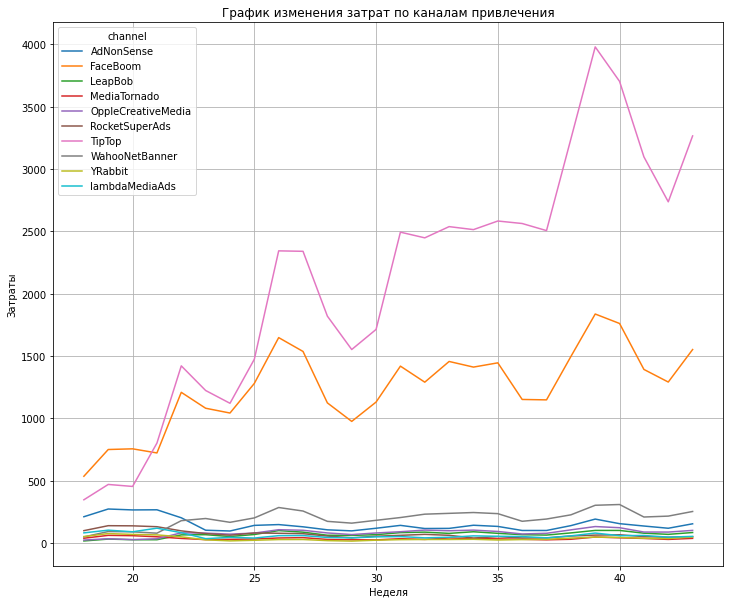

In [37]:
filtered_data = cost.pivot_table(
        index='week', columns='channel', values='costs', aggfunc='sum'
    )
filtered_data.plot(                                             
           figsize=(12, 10),
           grid=True,)

plt.title('График изменения затрат по каналам привлечения')
plt.xlabel('Неделя')
plt.ylabel('Затраты')
plt.show()

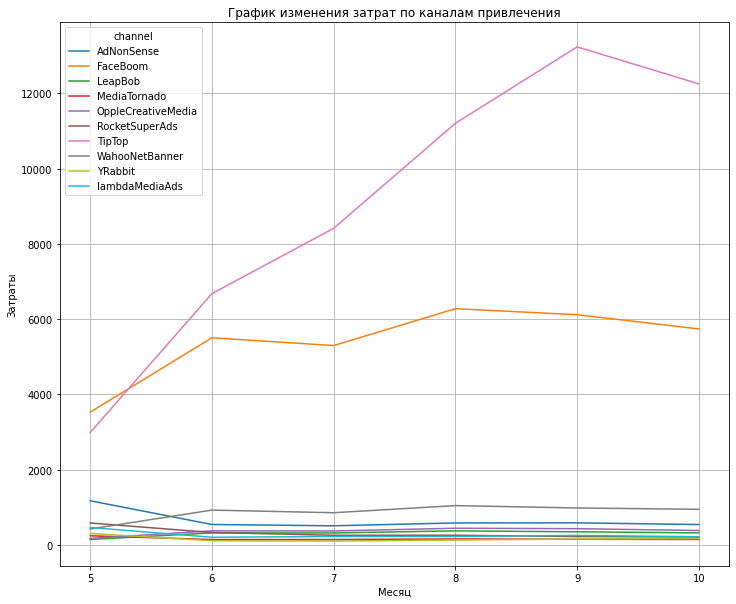

In [38]:
filtered_data = cost.pivot_table(
        index='month', columns='channel', values='costs', aggfunc='sum'
    )
filtered_data.plot(                                             
           figsize=(12, 10),
           grid=True,)

plt.title('График изменения затрат по каналам привлечения')
plt.xlabel('Месяц')
plt.ylabel('Затраты')
plt.show()

Согласно графику затраты на привелечение расли только относительно к FaceBoom и TipTop у остальных источников привлечения расходы стабильные.

#### САС по источникам

In [39]:
cac_by_channel = pd.DataFrame()

profiles = profiles.query('channel != "organic"')
cac_by_channel['acquisition_cost_mean'] = profiles.groupby('channel')['acquisition_cost'].mean()

cac_by_channel.sort_values(by='acquisition_cost_mean', ascending=False).style.format({'acquisition_cost_mean': '{:.2f}'})

,acquisition_cost_mean
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


Средний САС по источникам лидер TIpTop и FaceBoom

#### Вывод

Основыне расходы по привлечению пользователей распределены на FaceBoom и TipTop на них уходит до 80% всего бюджета на маркетинг.
В динамике расходы на меркетинг увеличевались только подвум источникам, это так же TIpTop и FaceBoom. Средняя цена привлечения так же самая высокая из источника TipTop но я мы рекомендовал снизить расход на данный источник так как по платязим пользователям из данного источника он всего лишь на 4 месте а затраты на первом.

### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

#### Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI

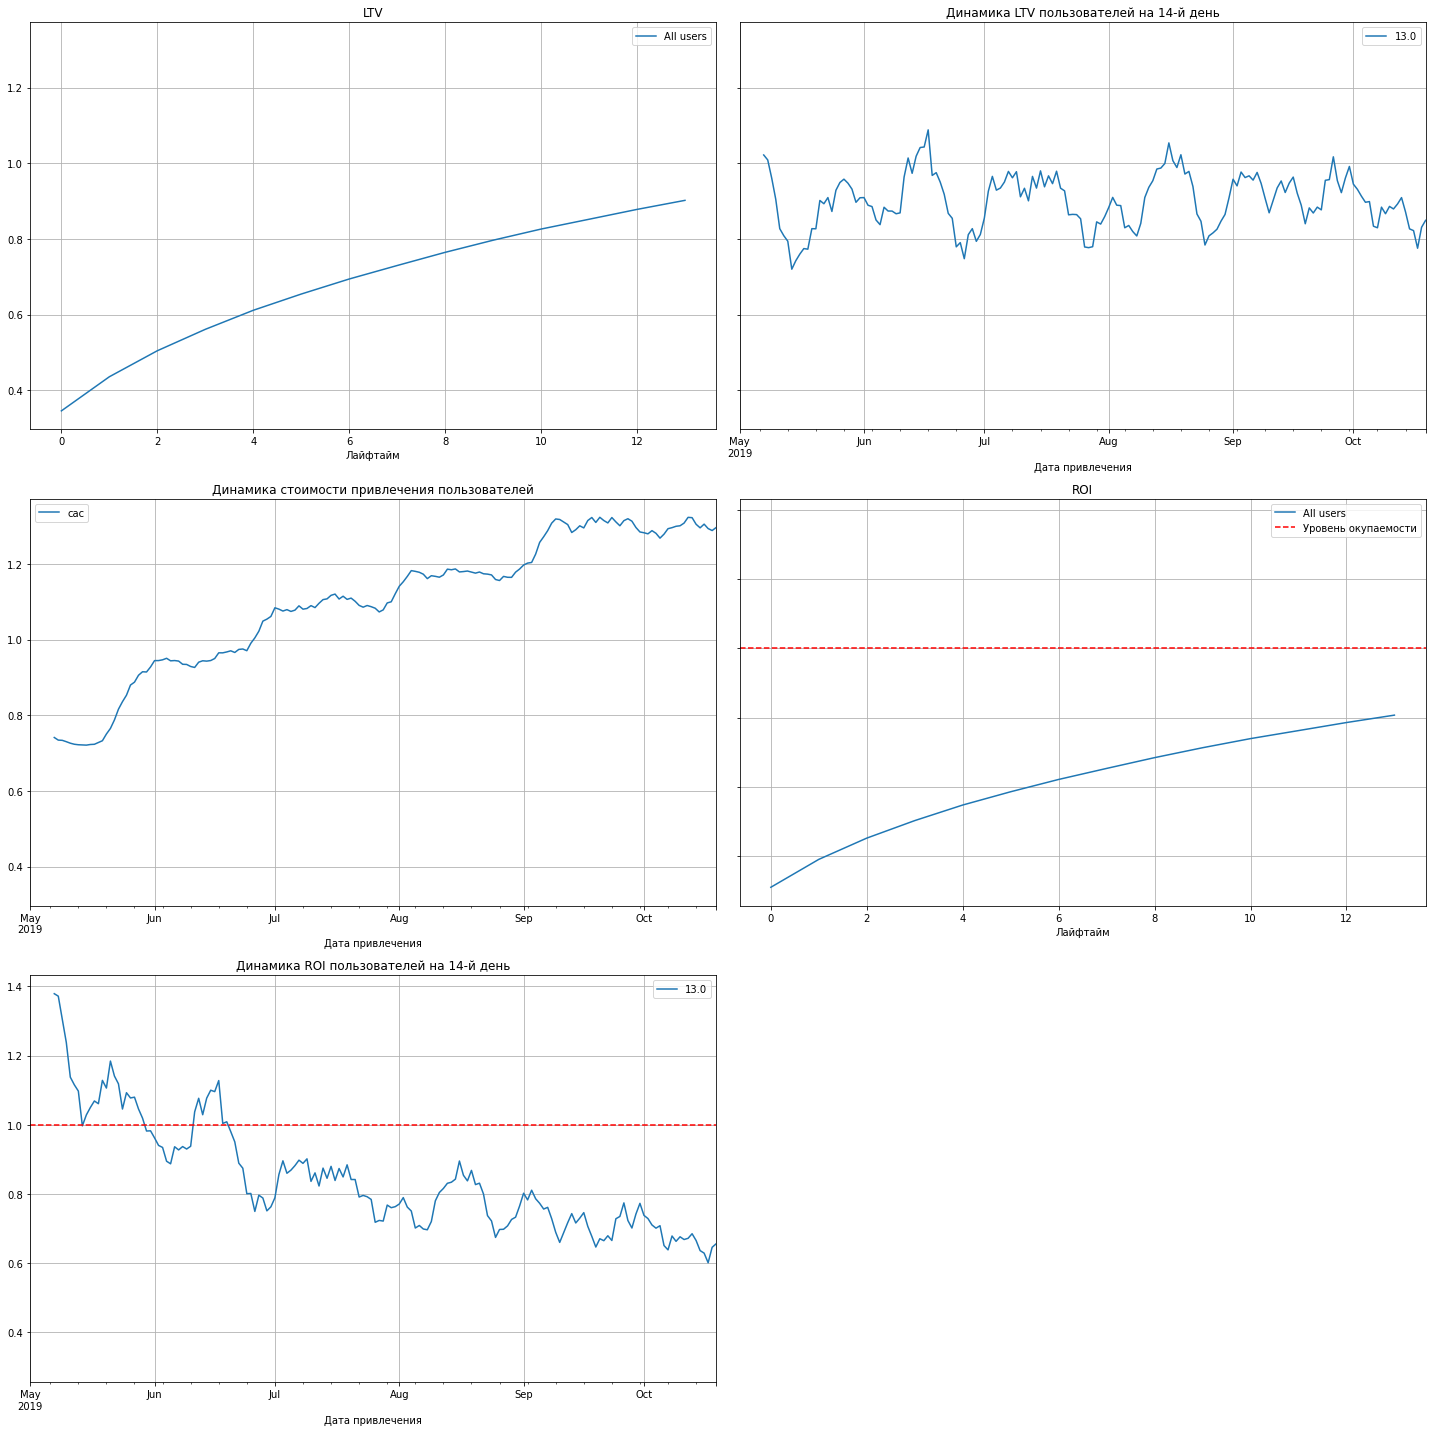

In [40]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, order, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

##### Вывод
LTV держится на примерно одном уровне на протяжении всего эксперимента
CAC на протяжении всего эксперимента растёт
ROI не доходит до уровня окупаемости.
Пользователи перестают окупаться уже в июне

#### Конверсия и удержание пользователей и динамика их изменений

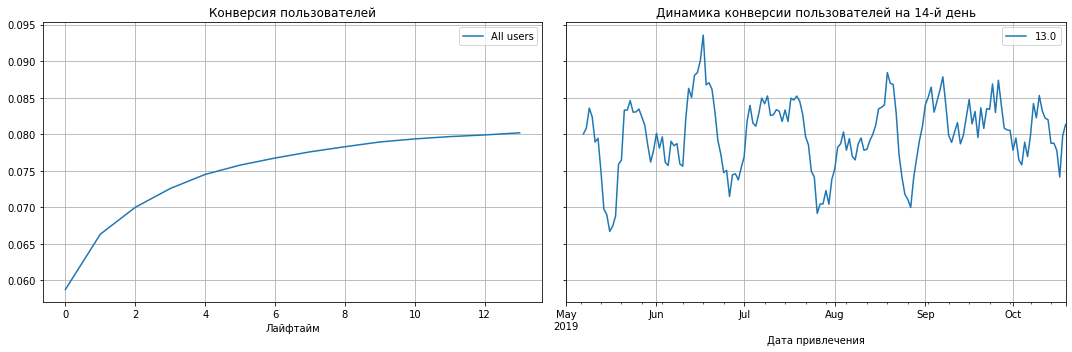

In [41]:
result_raw, result_grouped, result_in_time = get_conversion(
    profiles, order, observation_date, horizon_days
)
plot_conversion(result_grouped,result_in_time,horizon_days)

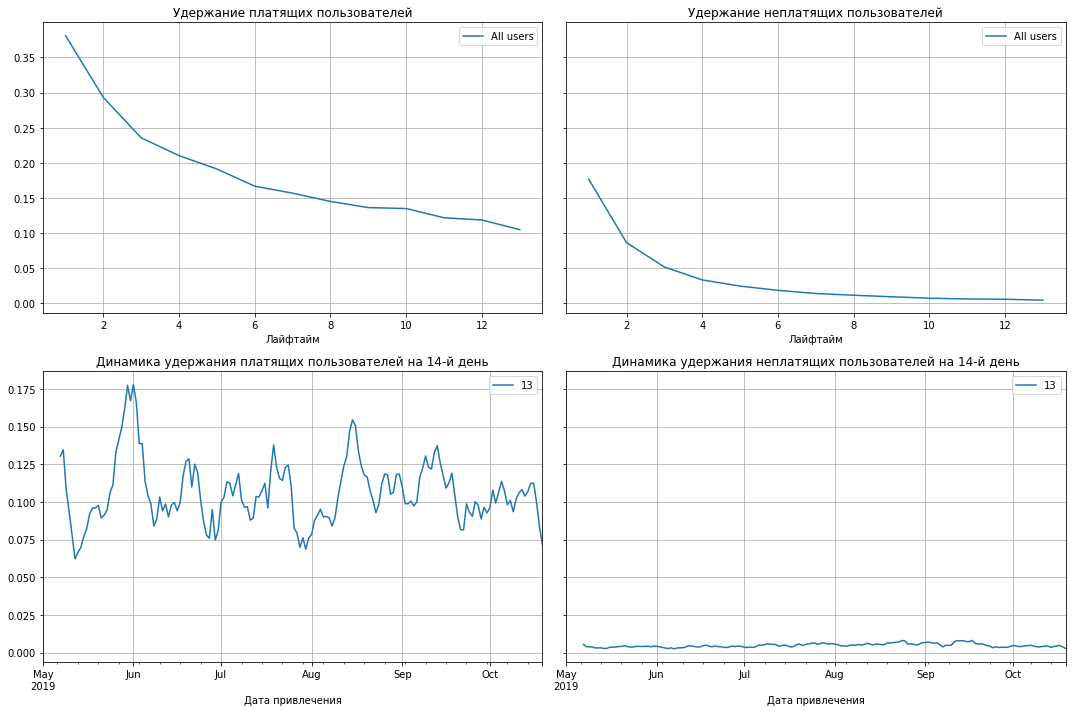

In [42]:
result_raw, result_grouped, result_in_time  = get_retention(
   profiles, order, observation_date, horizon_days
)
plot_retention(result_grouped, result_in_time,horizon_days)

##### Вывод

Конверсия пользователей в покупателя достигает к 14 дню - 8%, но ужечерез 2 недели начинаются проблемы и на графике динамики конверсии вины большие провалы.

Удержание платящих пользователей ожидаемо лучше чем у неплатящих, но неплатящие пользователи удерживаются совсем плохо

#### Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

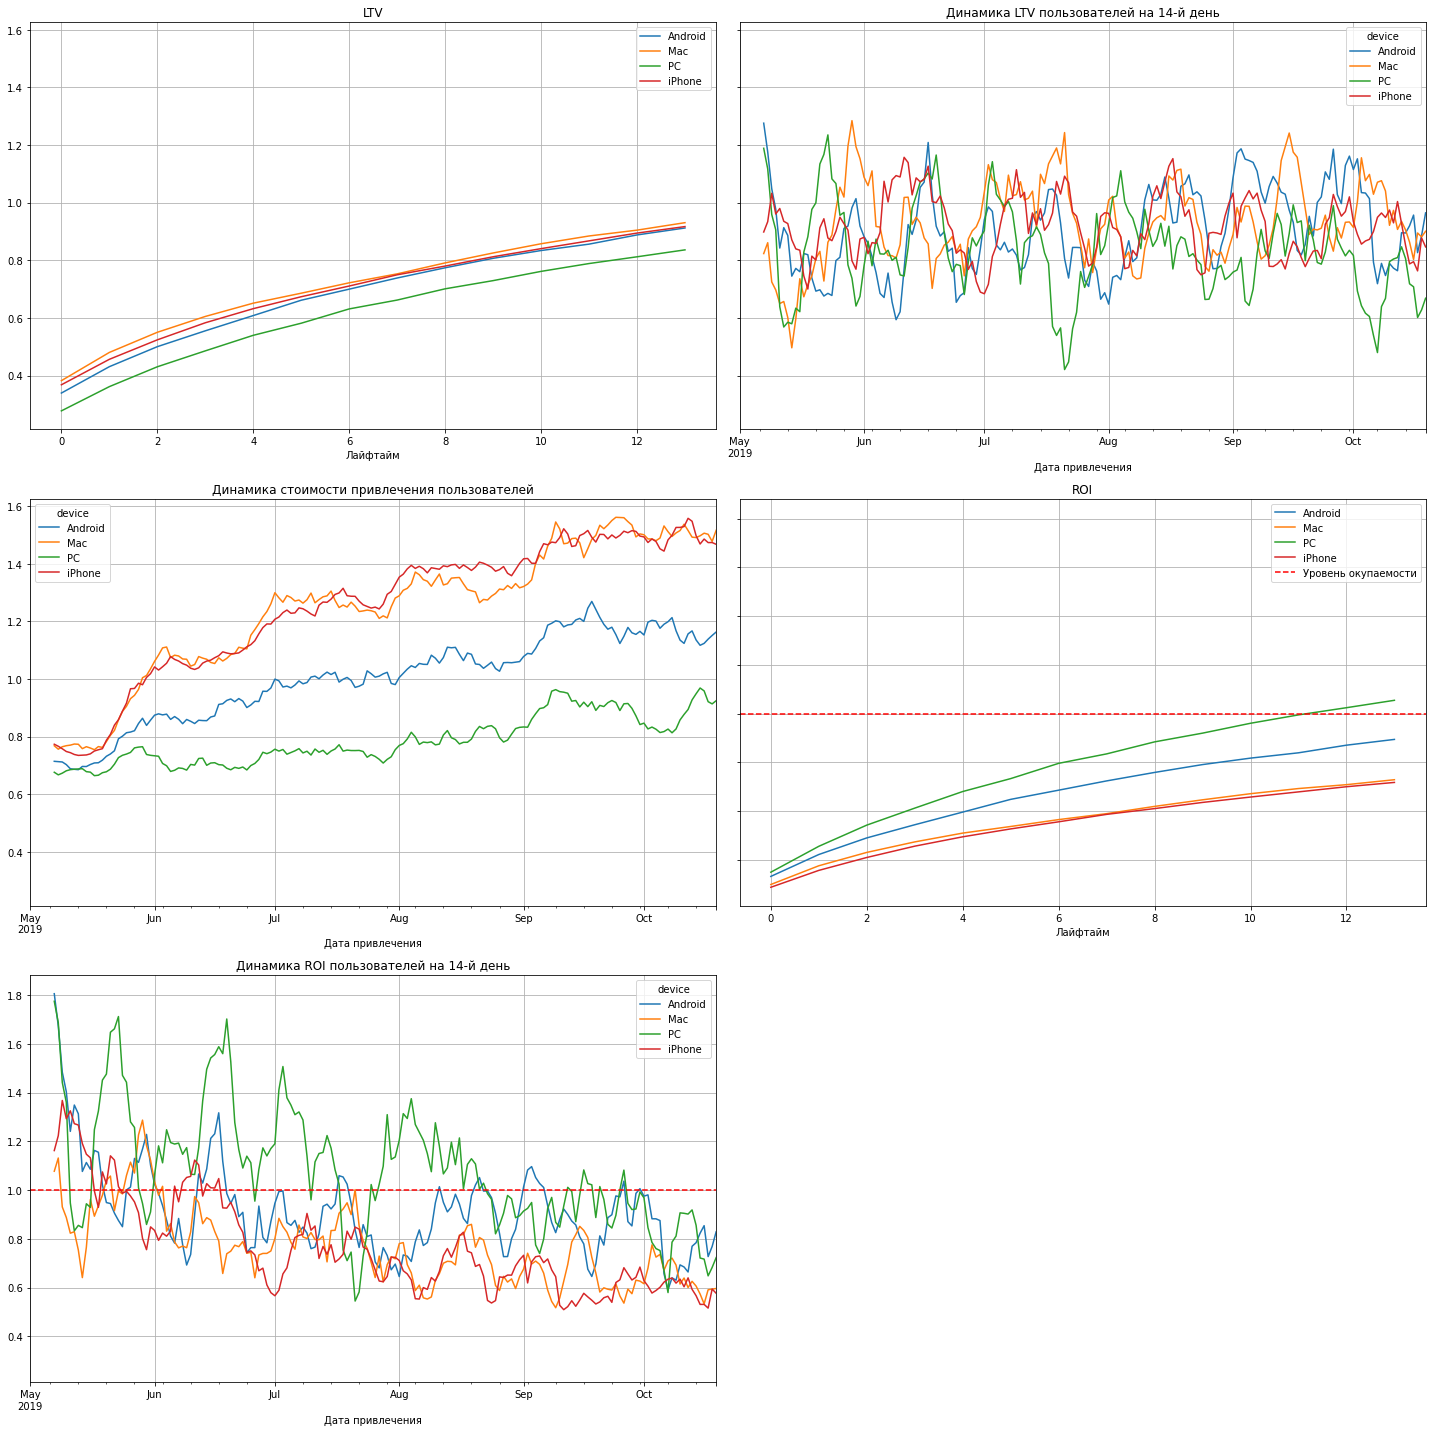

In [43]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, order, observation_date, horizon_days, dimensions=dimensions
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

##### Вывод

Бюджет на привлечение пользователей на платформе Iphone n Mac постоянно растет,но окупаеются лишь пользователи с платформы PC
LTV на всех платформах кромме PC очень близки друг к другу, значит в среднем не важно какой платформаой пользуется покупатель все они приносят одиннаковый доход.

#### Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI

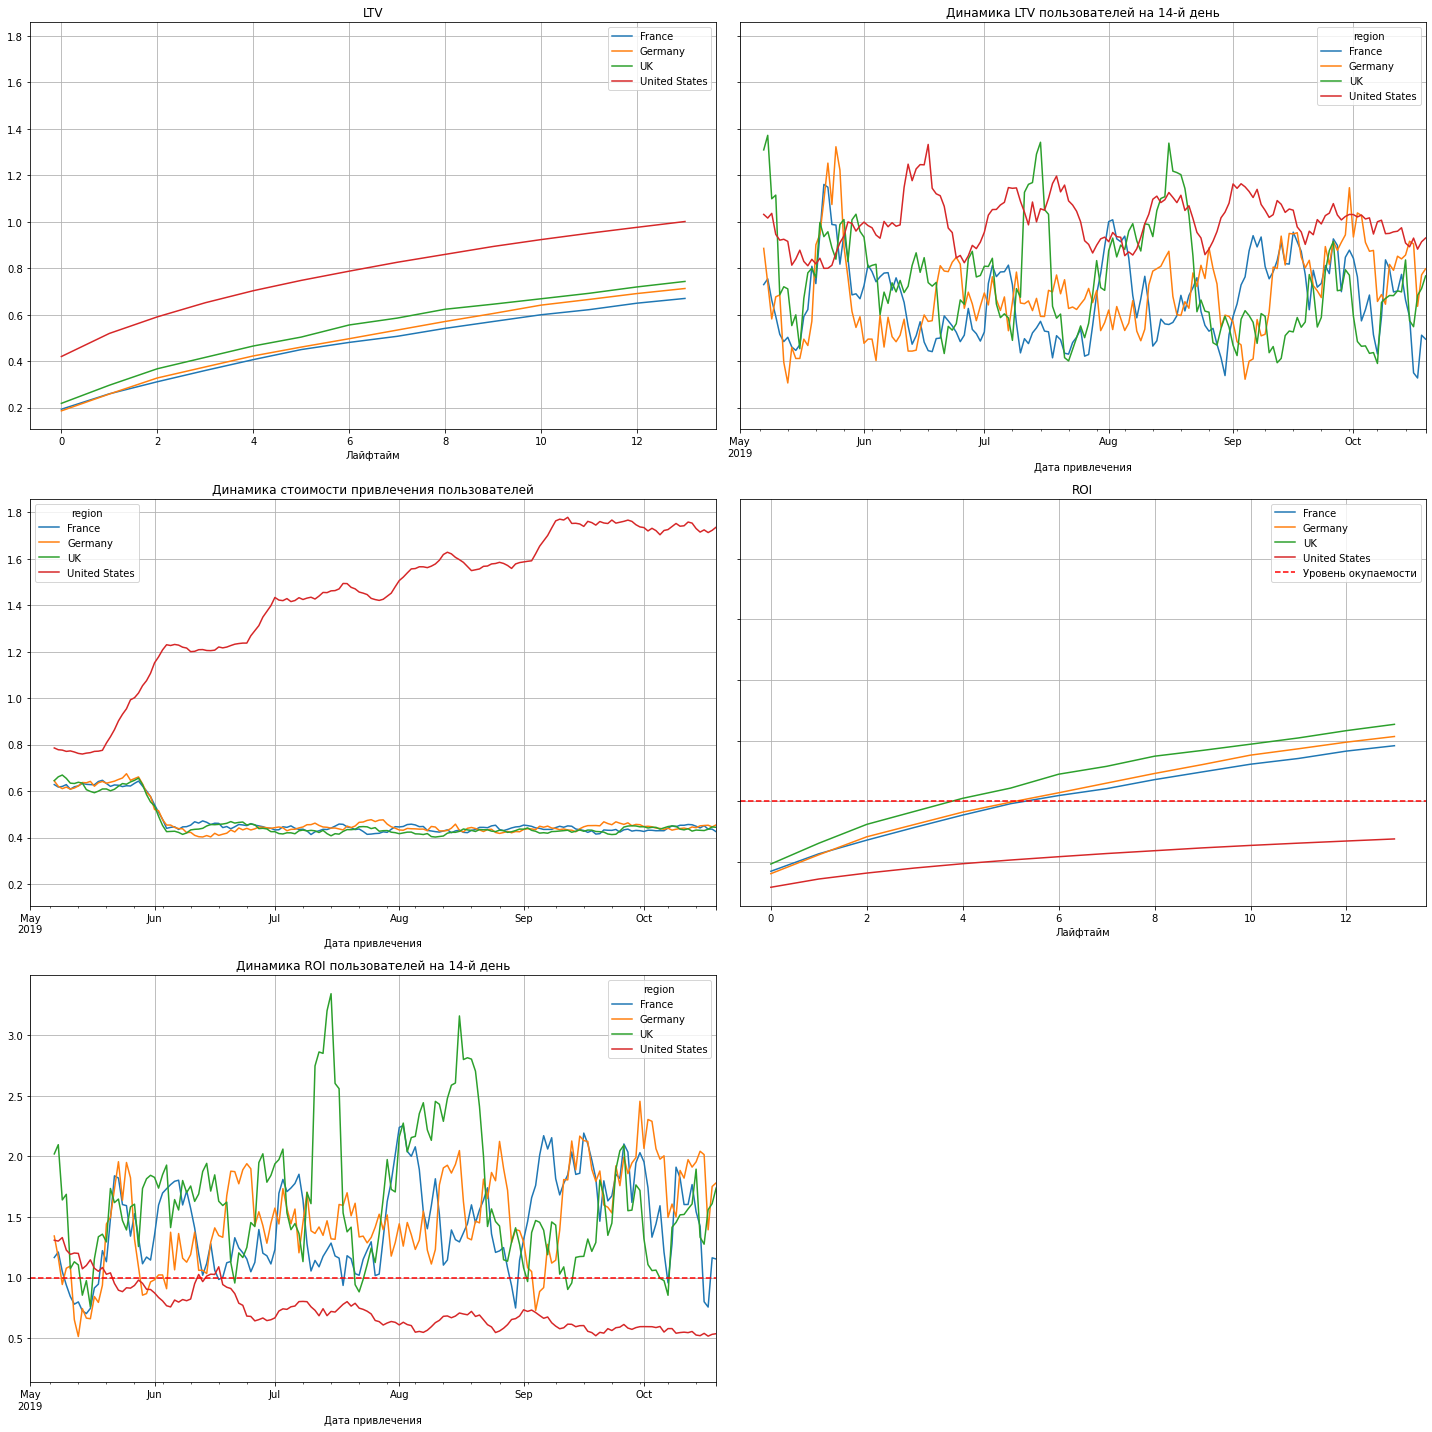

In [44]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, order, observation_date, horizon_days, dimensions=dimensions
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

##### Вывод
LTV пользователей из США самый высокий, но затраты на рекламу не окупаются
несмотря на огромное количество привлеченных пользователей из США, толку от них для приложения нет, они быстро приходят и так же быстро уходят,

затраты на рекламу в Европе остаются неизменными и окупаются, а вот в США растут и перестали окупаться с июня (видимо, благодаря вливаниям рекламных денег в TipTop

#### Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

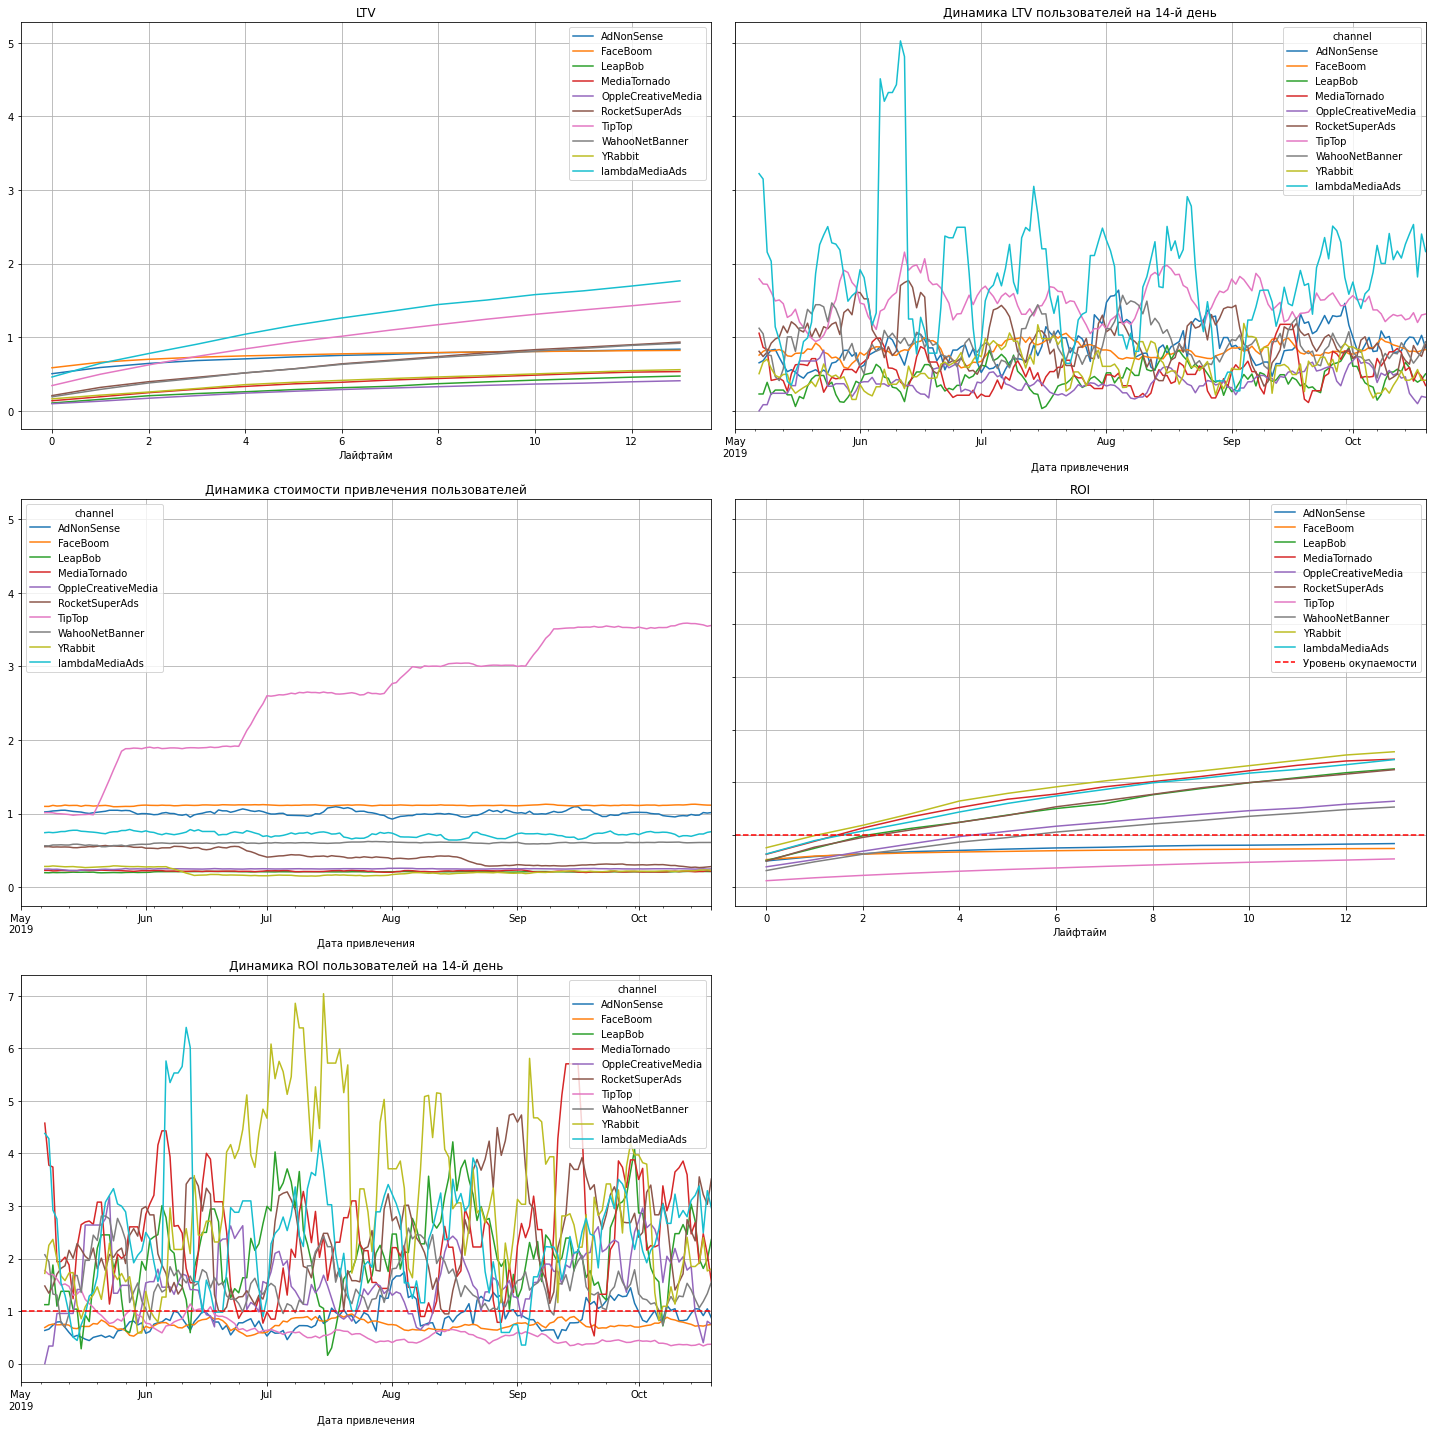

In [45]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, order, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days
) 

##### Вывод

На двухнедельном лайфтайме затраты на первую тройку компаний (на которые тратится практически весь рекламный бюджет) - не окупаются, затраты на рекламу в TipTop и FaceBoom вообще не окупаются, затратами на рекламу TipTop увеличиваются каждый месяц.

Окупаеммыми каналами привлечения являются все канала кроме Faceboom, Tiptop и adnonsence, остальные же окупаются на 2-6 день.


Перспективным каналом кажется lambdaMediaAds - низкая стоимость привлечения (0,72)и высокие показатели пожизненнаой ценности клиента.

##### Ответы
Окупается ли реклама, направленная на привлечение пользователей в целом?

Реклама не окупается к концу второй недели


Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?

Из стран USA снижает окупаемость рекламы. Из каналов: TipTop, FaceBoom, AdNonSense. Хуже всего удерживаются платящие пользователи устройств IPhone и MAC


Чем могут быть вызваны проблемы окупаемости?

Проблемы с окупаемостью вызваны неправильным распределением средств на привлечение с каналов
 TipTop самый невыгодный канал для привлечения, с которого большинство пользователей из страны USA. Также стоит обратить внимание на каналы откуда привлекаются платящие пользователи PC, потому что они удерживаются лучше всего

Дополнительный анализ

In [46]:
# Создадим срезы профилей отдельно по США и Европе:
profiles_amerika = profiles.query('region == "United States"')
profiles_eu = profiles.query('region != "United States"')

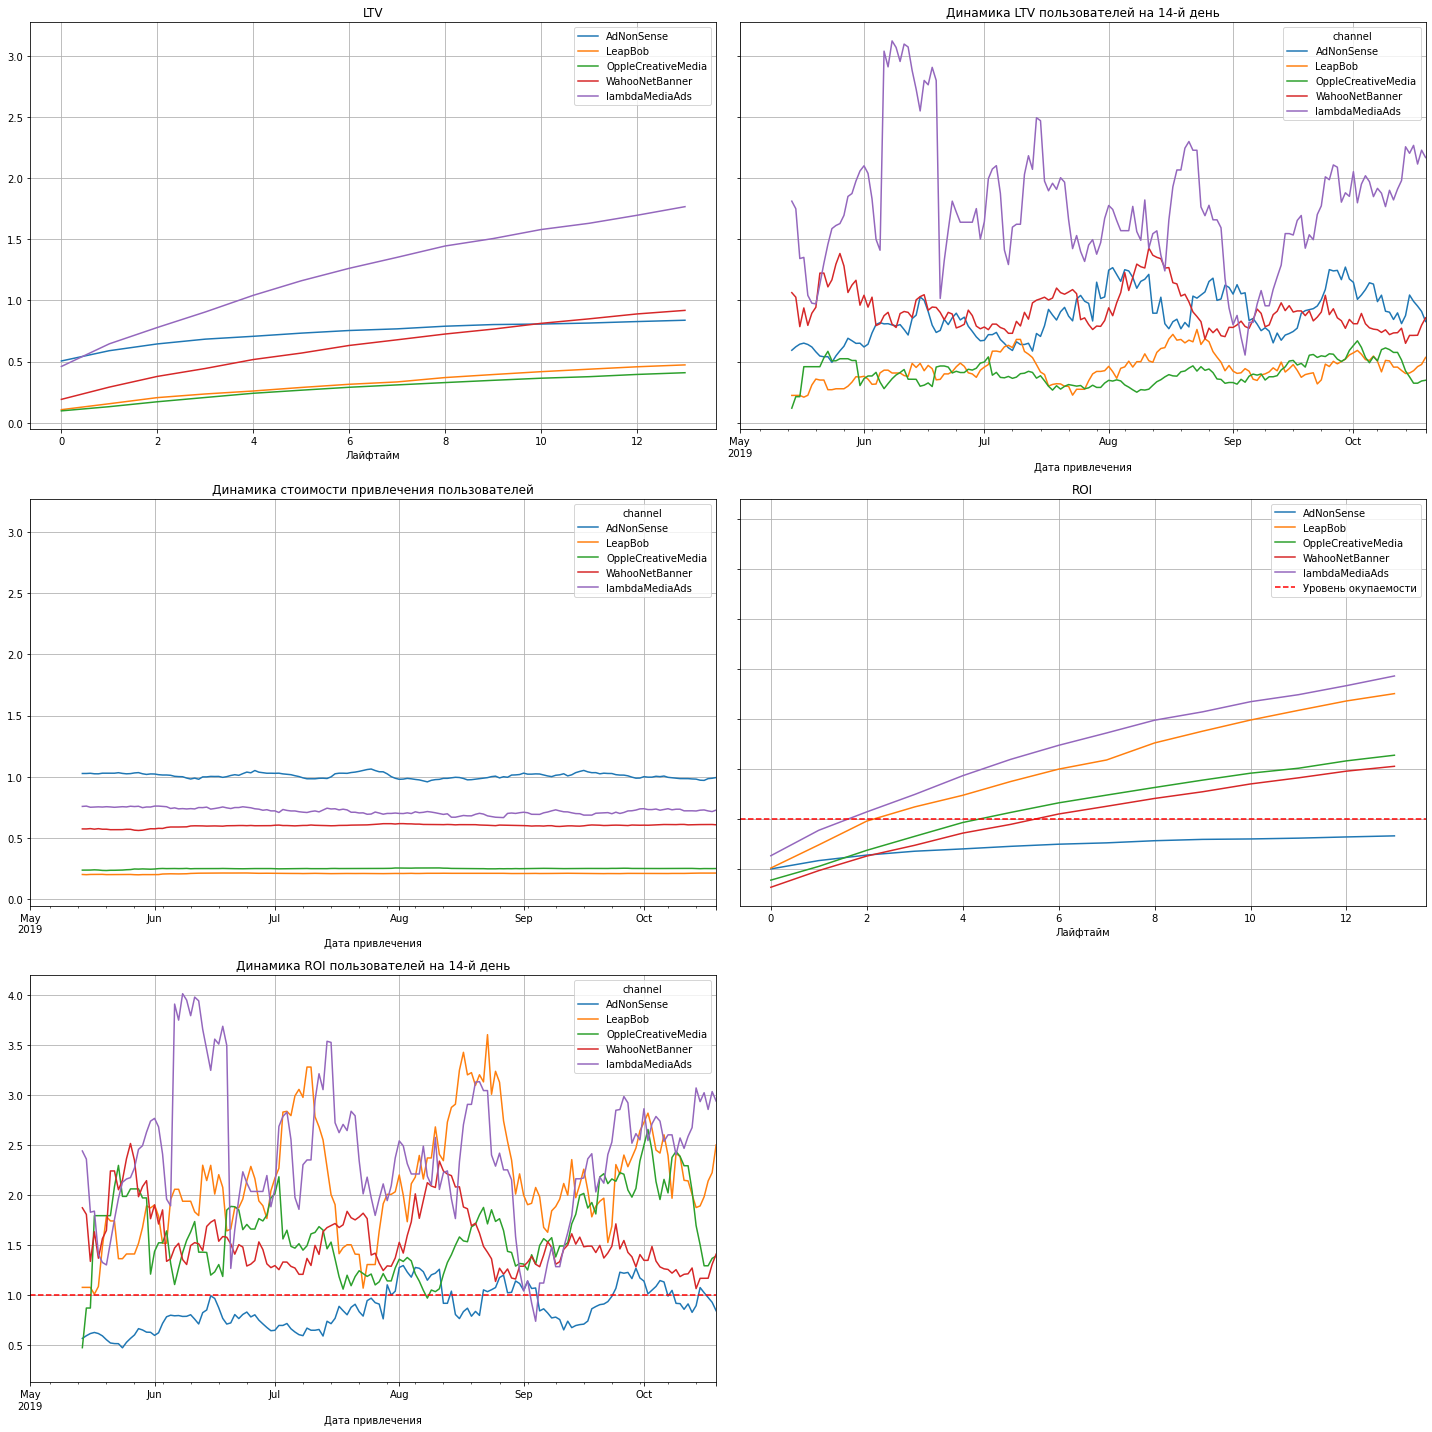

In [47]:
# Проверим окупаемость каналов в Европе
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_eu, order, observation_date, horizon_days, dimensions=['channel']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

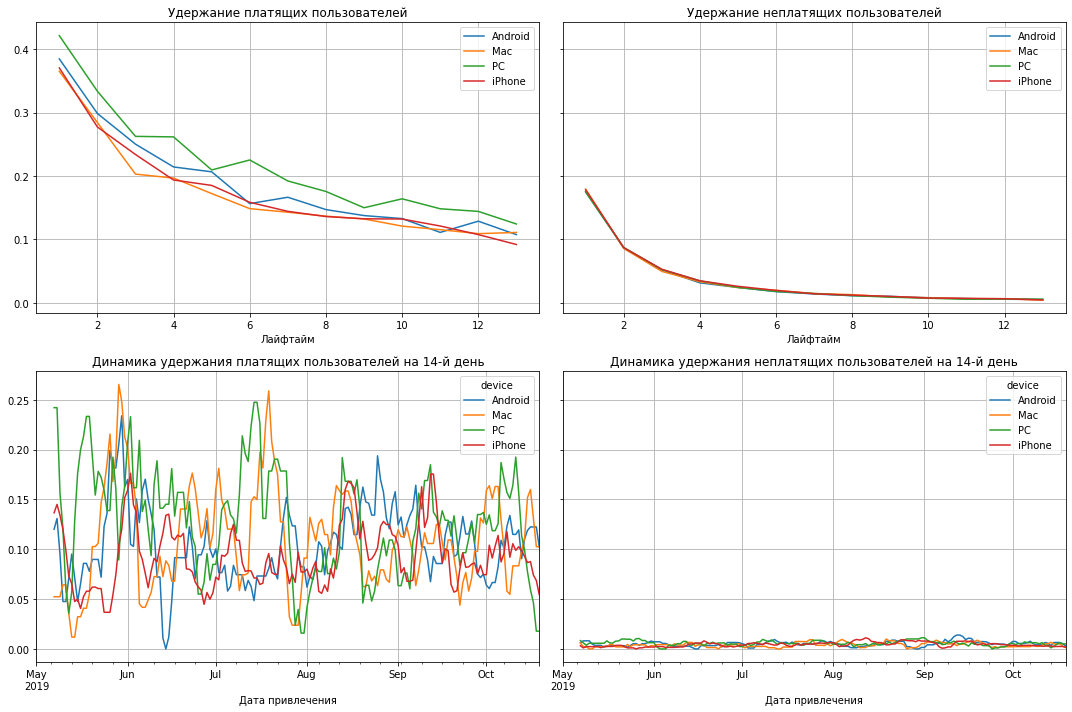

In [48]:
# посмотрим удержание с разбивкой по устройствам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visit, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

### Напишите выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

#### причины неэффективности привлечения пользователей

Три способа вложения средств, которые не приносили прибыли: AdNonSense, FaceBoom, TipTop. Основными клиентами среди этих каналов были жители США. Также, удержание клиентов, платящих из США, оказалось менее успешным по сравнению с другими странами. Анализ доходности по странам показал, что с каждым месяцем привлеченные платящие клиенты из США стали менее выгодными, при этом стоимость привлечения этих клиентов продолжала расти.

Возможные причины, связанные с проблемой рекламы в США:

Летом 2019 года произошло какое-то событие в США, которое значительно повлияло на поведение пользователей.
Пользователи устройств Mac и iPhone оказались наименее склонными к платежам, возможно, из-за проблем с оптимизацией приложения Procrastinate Pro+ для iOS устройств.
Рекламная система TipTop оказалась неэффективной и не оправдала вложенных средств. Возможно, в этой социальной сети преимущественно находились пользователи из других стран, использующие VPN.
Заметно необоснованное увеличение затрат на привлечение клиентов (CAC) в канале TipTop.
Касательно FaceBoom, конверсия пользователей была наивысшей, но удержание платящих клиентов оказалось наименьшим. Следует отметить, что этот канал успешно привлекал пользователей, но качество платного контента не удовлетворяло их, поэтому стоит сохранить этот канал и улучшить качество предоставляемого контента.

#### рекомендации для отдела маркетинга

Мы ищем новые методы для привлечения пользователей из Великобритании и Германии, с акцентом на компьютерных (PC) и Android пользователей. Следует обратить внимание на три недооцененных канала с высоким показателем возврата инвестиций (ROI): Yrabbit, MediaTornado и lambdaMediaAds.  В европе так же есть канал, который не окупается - AdNonSense, возможно стоит снизить траты на рекламу в нем.

На данный момент, удержание платящих клиентов на ПК идет успешно, но конверсия остается на низком уровне. Возможно, у нас есть потенциал, но стоит уделить внимание улучшению качества рекламы, чтобы привлечь больше клиентов.

Канал lambdaMediaAds имеет самый высокий показатель жизненной ценности клиентов (LTV). Это свидетельствует о том, что платящим пользователям нравится наш продукт. Мы можем попробовать найти более экономичные способы привлечения таких пользователей, чтобы увеличить ROI.

Учитывая, что большинство пользователей из США, мы должны улучшить наши отношения с рекламными площадками, ориентированными на этот регион. Как возможные шаги:

Рассмотреть отказ от канала FaceBoom и перераспределить рекламный бюджет на другие каналы.

Исследовать причины увеличения затрат на привлечение клиентов (CAC) в канале TipTop и, если возможно, устранить их. В противном случае, рассмотреть возможность замены этой рекламной площадки.

Обратить внимание на канал RocketSuperAds, который показывает низкий CAC, хорошие показатели привлечения и удержания клиентов, а также приемлемую конверсию.

Рассмотреть увеличение рекламных расходов в lambdaMediaAds и сокращение в AdNonSense, чтобы акцентировать внимание на европейском рынке.

Поднапрячь усилия по работе с органическими пользователями, так как они приносят значительную часть дохода приложения.